# Kaggle：房价预测

## 下载、访问数据集

In [4]:
import hashlib
import os
import tarfile
import zipfile
import requests

DATA_HUB = dict()
DATA_URL = 'http://d2l-data.s3-accelerate.amazonaws.com/'

下面的download函数用来下载数据集， 将数据集缓存在本地目录（默认情况下为../data）中， 并返回下载文件的名称。
如果缓存目录中已经存在此数据集文件，并且其sha-1与存储在DATA_HUB中的相匹配， 则将使用缓存的文件，以避免重复的下载。

In [5]:
def download(name, cache_dir=os.path.join('..', 'data')):
    """下载一个DATA_HUB中的文件，返回本地文件名"""
    assert name in DATA_HUB, f"{name} 不存在于 {DATA_HUB}"
    url, sha1_hash = DATA_HUB[name]
    # exist_ok表示如果这个目录存在也ok，False的话就会报错
    os.makedirs(cache_dir, exist_ok=True)
    # os.path.join 用于把目录和文件名合成一个路径
    fname = os.path.join(cache_dir, url.split('/')[-1])
    if os.path.exists(fname):
        sha1 = hashlib.sha1()
        with open(fname, 'rb') as f:
            while True:
                data = f.read(1048576)
                if not data:
                    break
                sha1.update(data)
        if sha1.hexdigest() == sha1_hash:
            return fname  # 命中缓存
    print(f'正在从{url}下载{fname}...')
    r = requests.get(url, stream=True, verify=True)
    with open(fname, 'wb') as f:
        f.write(r.content)
    return fname

两个实用函数： 一个将下载并解压缩一个zip或tar文件， 另一个是将本书中使用的所有数据集从DATA_HUB下载到缓存目录中。

In [6]:
def download_extract(name, folder=None):
    """下载并解压zip/tar文件"""
    fname = download(name)
    base_dir = os.path.dirname(fname)
    data_dir, ext = os.path.splitext(fname)
    if ext == '.zip':
        fp = zipfile.ZipFile(fname, 'r')
    elif ext in ('.tar', '.gz'):
        fp = tarfile.open(fname, 'r')
    else:
        assert False, '只有zip/tar文件可以被解压缩'
    fp.extractall(base_dir)
    return os.path.join(base_dir, folder) if folder else data_dir

def download_all():
    """下载DATA_HUB中的所有文件"""
    for name in DATA_HUB:
        download(name)

使用pandas读入并处理数据。

In [7]:
import numpy as np
import pandas as pd
import torch
from torch import nn

# 数据可以直接从kaggle上下载，也可以用d2l的hub下载
DATA_HUB['kaggle_house_train'] = (
    DATA_URL + 'kaggle_house_pred_train.csv',
    '585e9cc93e70b39160e7921475f9bcd7d31219ce')

DATA_HUB['kaggle_house_test'] = (
    DATA_URL + 'kaggle_house_pred_test.csv',
    'fa19780a7b011d9b009e8bff8e99922a8ee2eb90')

train_data = pd.read_csv(download('kaggle_house_train'))
test_data = pd.read_csv(download('kaggle_house_test'))

print(train_data.shape)
print(test_data.shape)

(1460, 81)
(1459, 80)


In [8]:
print(train_data.iloc[0:4, [0, 1, 2, 3, -3, -2, -1]])

# 把训练集和测试集纵向并列，删除ID列（无用数据，不能帮助预测）
# 同时去掉train_data的最后一列，这一列是标签并非特征
all_features = pd.concat((train_data.iloc[:, 1:-1], test_data.iloc[:, 1:]))

   Id  MSSubClass MSZoning  LotFrontage SaleType SaleCondition  SalePrice
0   1          60       RL         65.0       WD        Normal     208500
1   2          20       RL         80.0       WD        Normal     181500
2   3          60       RL         68.0       WD        Normal     223500
3   4          70       RL         60.0       WD       Abnorml     140000


## 数据预处理

先处理数值

In [9]:
# 若无法获得测试数据，则可根据训练数据计算均值和标准差
# 获取所有非object元素的索引，string由于是变长的，所以被numpy归为object类型
# pandas的Dataframe使用了numpy的object类型，pandas支持的数据类型：
# 1. float
# 2. int
# 3. bool
# 4. datetime64[ns]
# 5. datetime64[ns, tz]
# 6. timedelta[ns]
# 7. category
# 8. object

numeric_features = all_features.dtypes[all_features.dtypes != 'object'].index
# 对所有索引位置的元素实施标准化，应用了匿名函数
all_features[numeric_features] = all_features[numeric_features].apply(
    lambda x: (x - x.mean()) / (x.std()))
# 在标准化数据之后，所有原值为均值的元素消失，可以将缺失值设置为0
all_features[numeric_features] = all_features[numeric_features].fillna(0)

离散值处理，独热编码（我更愿意称之为 单项编码）

In [10]:
# “Dummy_na=True”将“na”（缺失值）视为有效的特征值，并为其创建一个特征。
all_features = pd.get_dummies(all_features, dummy_na=True)
all_features.shape

(2919, 331)

In [11]:
# 得到训练集样本数量
n_train = train_data.shape[0]
# 提取训练集特征
train_features = torch.tensor(all_features[:n_train].values, dtype=torch.float32)
# 提取测试集特征
test_features = torch.tensor(all_features[n_train:].values, dtype=torch.float32)
# 提取训练集真实标签
train_labels = torch.tensor(train_data.SalePrice.values.reshape(-1, 1), dtype=torch.float32)

## 绘图函数

In [12]:
from matplotlib_inline import backend_inline
import matplotlib.pyplot as plt
from IPython import display

def use_svg_display():
    """使用svg格式在Jupyter中显示绘图"""
    backend_inline.set_matplotlib_formats('svg')

def set_figsize(figsize=(3.5, 2.5)):
    """设置matplotlib的图表大小"""
    use_svg_display()
    plt.rcParams['figure.figsize'] = figsize

def set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend):
    """设置matplotlib的轴"""
    axes.set_xlabel(xlabel)
    axes.set_ylabel(ylabel)
    axes.set_xscale(xscale)
    axes.set_yscale(yscale)
    axes.set_xlim(xlim)
    axes.set_ylim(ylim)
    if legend:
        axes.legend(legend)
    axes.grid()

def plot(X, Y=None, xlabel=None, ylabel=None, legend=None, xlim=None,
         ylim=None, xscale='linear', yscale='linear',
         fmts=('-', 'm--', 'g-.', 'r:'), figsize=(3.5, 2.5), axes=None):
    """绘制数据点"""
    if legend is None:
        legend = []

    set_figsize(figsize)
    axes = axes if axes else plt.gca()

    # 如果X有一个轴，输出True
    def has_one_axis(X):
        return (hasattr(X, "ndim") and X.ndim == 1 or isinstance(X, list)
                and not hasattr(X[0], "__len__"))

    if has_one_axis(X):
        X = [X]
    if Y is None:
        X, Y = [[]] * len(X), X
    elif has_one_axis(Y):
        Y = [Y]
    if len(X) != len(Y):
        X = X * len(Y)
    axes.cla()
    for x, y, fmt in zip(X, Y, fmts):
        if len(x):
            axes.plot(x, y, fmt)
        else:
            axes.plot(y, fmt)
    set_axes(axes, xlabel, ylabel, xlim, ylim, xscale, yscale, legend)

## 训练

先练一个线性模型，作为baseline。

In [13]:
#均方损失
loss = nn.MSELoss()
# 输入的特征
in_features = train_features.shape[1]

def get_net():
    # 输入为特征数量（331），输出1
    net = nn.Sequential(nn.Linear(in_features,1))
    return net

基于更关心相对值的考虑，采用求对数后求均方根误差。

In [14]:
def log_rmse(net, features, labels):
    # 为了在取对数时进一步稳定该值，将小于1的值设置为1
    # torch.clamp将输入net(features)张量每个元素的范围限制到区间 [1,inf]，返回结果到一个新张量。z
    clipped_preds = torch.clamp(net(features), 1, float('inf'))
    # MSE开方就是RMSE了
    rmse = torch.sqrt(loss(torch.log(clipped_preds),torch.log(labels)))
    return rmse.item()

训练函数将借助Adam优化器，Adam优化器的主要吸引力在于它对初始学习率不那么敏感。

In [15]:
from torch.utils import data

def load_array(data_arrays, batch_size, is_train=True):
    """构造一个PyTorch数据迭代器"""
    #把传入的tuple解包作为两个参数输入TensorDataset函数，即特征和标签，需要样本数量对应。
    dataset = data.TensorDataset(*data_arrays)
    # DataLoader本质上就是一个iterable（跟python的内置类型list等一样），并利用多进程来加速batch data的处理，使用yield来使用有限的内存
    # 会将一个数据集（dataset）和一个采样器（sampler）结合。
    return data.DataLoader(dataset, batch_size, shuffle=is_train)

def train(net, train_features, train_labels, test_features, test_labels,
          num_epochs, learning_rate, weight_decay, batch_size):
    # 训练损失、测试损失
    train_ls, test_ls = [], []
    # 训练集迭代器
    train_iter = load_array((train_features, train_labels), batch_size)
    # 这里使用的是Adam优化算法，传入提供的学习率和权重衰减
    optimizer = torch.optim.Adam(net.parameters(),
                                 lr = learning_rate,
                                 weight_decay = weight_decay)
    # 周期训练
    for epoch in range(num_epochs):
        for X, y in train_iter:
            optimizer.zero_grad()
            # 这个损失还是MSE，why？
            l = loss(net(X), y)
            l.backward()
            optimizer.step()
        train_ls.append(log_rmse(net, train_features, train_labels))
        if test_labels is not None:
            test_ls.append(log_rmse(net, test_features, test_labels))
    return train_ls, test_ls

## K折交叉验证

In [16]:
def get_k_fold_data(k, i, X, y):
    """该函数负责在K折交叉验证过程中返回第i折的数据"""
    assert k > 1
    fold_size = X.shape[0] // k
    X_train, y_train = None, None
    for j in range(k):
        # slice 对象用于指定如何对序列进行裁切。可以指定在哪里开始裁切以及在哪里结束裁切，以及指定步长。
        idx = slice(j * fold_size, (j + 1) * fold_size)
        # 取特征、标签对应的部分
        X_part, y_part = X[idx, :], y[idx]
        # 第i折为验证数据
        if j == i:
            X_valid, y_valid = X_part, y_part
        # 其余为训练数据
        elif X_train is None:
            X_train, y_train = X_part, y_part
        else:
            # 在给定维度上对输入的张量序列进行连接操作，此处维度为0
            X_train = torch.cat([X_train, X_part], 0)
            y_train = torch.cat([y_train, y_part], 0)
    return X_train, y_train, X_valid, y_valid

在K折交叉验证中训练K次后，返回训练和验证误差的平均值。

In [17]:
def k_fold(k, X_train, y_train, num_epochs, learning_rate, weight_decay,
           batch_size):
    """K折交叉验证，返回平均训练误差与平均验证误差"""
    train_l_sum, valid_l_sum = 0, 0
    for i in range(k):
        data = get_k_fold_data(k, i, X_train, y_train)
        net = get_net()
        train_ls, valid_ls = train(net, *data, num_epochs, learning_rate,
                                   weight_decay, batch_size)
        # 累加训练误差与验证误差
        train_l_sum += train_ls[-1]
        valid_l_sum += valid_ls[-1]
        if i == 0:
            plot(list(range(1, num_epochs + 1)), [train_ls, valid_ls],
                     xlabel='epoch', ylabel='rmse', xlim=[1, num_epochs],
                     legend=['train', 'valid'], yscale='log')
        print(f'折{i + 1}，训练log rmse{float(train_ls[-1]):f}, 'f'验证log rmse{float(valid_ls[-1]):f}')
    return train_l_sum / k, valid_l_sum / k

## 模型选择

折1，训练log rmse0.170322, 验证log rmse0.157163
折2，训练log rmse0.161947, 验证log rmse0.188191
折3，训练log rmse0.164309, 验证log rmse0.168666
折4，训练log rmse0.168034, 验证log rmse0.154845
折5，训练log rmse0.163295, 验证log rmse0.183052
5-折验证: 平均训练log rmse: 0.165581, 平均验证log rmse: 0.170383


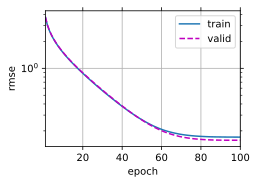

In [19]:
k, num_epochs, lr, weight_decay, batch_size = 5, 100, 5, 0, 64
train_l, valid_l = k_fold(k, train_features, train_labels, num_epochs, lr,
                          weight_decay, batch_size)
print(f'{k}-折验证: 平均训练log rmse: {float(train_l):f}, '
      f'平均验证log rmse: {float(valid_l):f}')

## 预测

训练log rmse：0.162453


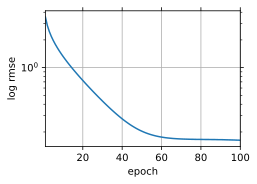

In [20]:
def train_and_pred(train_features, test_features, train_labels, test_data,
                   num_epochs, lr, weight_decay, batch_size):
    net = get_net()
    train_ls, _ = train(net, train_features, train_labels, None, None,
                        num_epochs, lr, weight_decay, batch_size)
    plot(np.arange(1, num_epochs + 1), [train_ls], xlabel='epoch',
             ylabel='log rmse', xlim=[1, num_epochs], yscale='log')
    print(f'训练log rmse：{float(train_ls[-1]):f}')
    # 将网络应用于测试集。
    # ？
    preds = net(test_features).detach().numpy()
    # 将其重新格式化以导出到Kaggle
    # ？
    test_data['SalePrice'] = pd.Series(preds.reshape(1, -1)[0])
    submission = pd.concat([test_data['Id'], test_data['SalePrice']], axis=1)
    submission.to_csv('submission.csv', index=False)


train_and_pred(train_features, test_features, train_labels, test_data,
               num_epochs, lr, weight_decay, batch_size)